MIT Election Data and Science Lab, 2018, "County Presidential Election Returns 2000-2016"

US Census

In [792]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns

from arcgis.geocoding import geocode
from arcgis.gis import GIS
from dotenv import load_dotenv
from functools import reduce
from shapely.geometry import Point, Polygon
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.svm import SVC, SVR
from textwrap import wrap
from xgboost import XGBClassifier, XGBRegressor, plot_importance

%matplotlib inline
plt.style.use("ggplot")
sns.set_context("talk")

In [28]:
load_dotenv("")
censuskey = os.getenv("censuskey")

In [ ]:
var_description = pd.DataFrame(pd.DataFrame(
    requests.get("https://api.census.gov/data/2017/acs/acs5/profile/variables.json")
                                            .json()["variables"])
                               .T.iloc[:, 3]
                               .str.title()
                               .str.replace("!!", " ", regex=True)
                               .str.replace("Percent Estimate ", " ", regex=True))

In [827]:
var_description.to_csv("../data/var_description.csv")

In [121]:
variables = pd.DataFrame(requests.get(
    "https://api.census.gov/data/2017/acs/acs5/profile/variables.json").json()["variables"].keys(),
                         columns=["index_name"])

In [161]:
variables_selected = variables.loc[((~variables.index_name.str.contains(r'DP')|
                                     (variables.index_name.str.contains(r'DP')&
                                      variables.index_name.str.contains(r'[0-9]PE')))&
                                    ~variables.index_name.str.contains(r'PR_'))]

In [162]:
len(variables_selected)

558

In [951]:
resp = requests.get(
    "https://api.census.gov/data/2017/acs/acs5/profile?get=NAME&for=county:*&in=state:*&key={}"
    .format(censuskey))

In [952]:
county = pd.DataFrame(resp.json()[1:], columns=resp.json()[0])

In [953]:
location_df = county.NAME.apply(lambda x: geocode(x)[0]['location'])
county["longitude"] = location_df.apply(lambda x: x["x"])
county["latitude"] = location_df.apply(lambda x: x["y"])

In [954]:
fips_dict = {}
for i in range(len(county.NAME)):
    param=({"lat": county.latitude[i],
            "lon": county.longitude[i],
            'showall':'false'})
    
    resp = requests.get("https://geo.fcc.gov/api/census/block/find", param)
    try:
        fips_dict[county.NAME[i]] = resp.json()['results'][0]["block_fips"]
    except:
        print(county.NAME[i])

Añasco Municipio, Puerto Rico
Aibonito Municipio, Puerto Rico
Aguada Municipio, Puerto Rico
Adjuntas Municipio, Puerto Rico


In [955]:
county = pd.merge(county, pd.DataFrame(fips_dict, index=["FIPS"]).T, left_on="NAME", right_index=True, how="left")

In [1042]:
county_poly = county

In [1043]:
county_poly = county_poly.loc[~county_poly.FIPS.isnull()]

In [1044]:
county_poly["state_county"] = county_poly.state + county_poly.county

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [795]:
#read in once, large geospatial Dataframe
# df_places = gpd.read_file('../data/cbg.geojson')

In [967]:
df_places.head()

,StateFIPS,CountyFIPS,TractCode,BlockGroup,CensusBlockGroup,State,County,ClassCode,geometry,state_county
0,01,081,041600,1,010810416001,AL,Lee County,H1,(POLYGON ((-85.37281500011215 32.6342380002835...,01081
1,01,081,041600,2,010810416002,AL,Lee County,H1,(POLYGON ((-85.38346400016343 32.6483780003445...,01081
2,01,081,041700,4,010810417004,AL,Lee County,H1,(POLYGON ((-85.37139200014064 32.6013869998102...,01081
3,01,073,011107,4,010730111074,AL,Jefferson County,H1,(POLYGON ((-86.64796800012306 33.5920459996232...,01073
4,01,073,011108,4,010730111084,AL,Jefferson County,H1,(POLYGON ((-86.65205899992287 33.5986850000127...,01073


In [927]:
df_places["state_county"] = df_places.CensusBlockGroup.str[:5]

In [1045]:
county_poly = pd.merge(county_poly, 
                       df_places[["state_county", "geometry"]],  
                       on="state_county", 
                       how="left")

In [1052]:
county_poly.FIPS = county_poly.FIPS.astype(int)

In [1054]:
county_poly.shape

(220255, 8)

In [1048]:
county_poly.head()

,NAME,state,county,longitude,latitude,FIPS,state_county,geometry
0,"Pickens County, Alabama",01,107,-88.088689,33.280982,011070503001018,01107,(POLYGON ((-88.05802999998446 33.5277660004006...
1,"Pickens County, Alabama",01,107,-88.088689,33.280982,011070503001018,01107,(POLYGON ((-88.12121399992611 33.3661849999378...
2,"Pickens County, Alabama",01,107,-88.088689,33.280982,011070503001018,01107,(POLYGON ((-88.29300600002682 33.3829620001961...
3,"Pickens County, Alabama",01,107,-88.088689,33.280982,011070503001018,01107,(POLYGON ((-88.2530249999038 33.21150300016336...
4,"Pickens County, Alabama",01,107,-88.088689,33.280982,011070503001018,01107,(POLYGON ((-88.15581600020823 33.2788679995586...


In [939]:
county.head()

,NAME,state,county,longitude,latitude,FIPS
0,"Pickens County, Alabama",01,107,-88.088689,33.280982,011070503001018
1,"Pickens County, Alabama",01,107,-88.088689,33.280982,011070503001018
2,"Pickens County, Alabama",01,107,-88.088689,33.280982,011070503001018
3,"Pickens County, Alabama",01,107,-88.088689,33.280982,011070503001018
4,"Pickens County, Alabama",01,107,-88.088689,33.280982,011070503001018


In [865]:
county.to_csv("../data/county.csv")

In [157]:
varlist = []
for var in variables_selected.index_name:
    resp = requests.get(
        "https://api.census.gov/data/2017/acs/acs5/profile?get={}&for=county:*&in=state:*&key={}"
        .format(var, censuskey))
    if resp.status_code ==200:
        varlist.append(pd.DataFrame(resp.json()[1:], columns=resp.json()[0]))

In [158]:
df_merged = reduce(lambda left, right: pd.merge(left, right, how='outer'), varlist)

In [177]:
df_merged.dropna(axis=1, inplace=True)

In [872]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220 entries, 0 to 3219
Columns: 375 entries, DP05_0050PE to DP04_0095PE
dtypes: object(375)
memory usage: 9.2+ MB


In [873]:
df_clean = pd.concat([df_merged.loc[:, ~df_merged.columns.str.contains(r'[0-9]PE')].
                    drop(columns=["STATE", "COUNTY"]),
                    df_merged.loc[:, df_merged.columns.str.contains(r'[0-9]PE')]
                    .loc[:, ((df_merged.loc[:, df_merged.columns.str.contains(r'[0-9]PE')].max()<100)&
                             (df_merged.loc[:, df_merged.columns.str.contains(r'[0-9]PE')].min()>=0))]],
                     axis=1
                   )

In [874]:
df_clean = pd.merge(county, df_clean, on = ["state", "county"])

In [875]:
df_clean.county = df_clean.NAME.str.split(',', expand=True
                                         ).loc[:, 0].replace({" County":"",
                                                              " Municipio":"",
                                                              " city": "",
                                                              " Parish":""
                                                             }, regex=True)
df_clean.state = df_clean.NAME.str.split(',', expand=True).loc[:, 1].map(
    lambda x: x.lstrip(" "))
df_clean.iloc[1149, 2] = "Baltimore City"
df_clean.iloc[1530, 2] = "St. Louis County"
df_clean.iloc[1570, 2] = "St. Louis City"
df_clean.head()

,NAME,state,county,longitude,latitude,FIPS,GEO_ID,GEOCOMP,DP05_0050PE,DP03_0048PE,...,DP04_0140PE,DP05_0010PE,DP04_0118PE,DP05_0054PE,DP04_0051PE,DP05_0041PE,DP04_0082PE,DP04_0105PE,DP03_0115PE,DP03_0039PE
0,"Pickens County, Alabama",Alabama,Pickens,-88.088689,33.280982,011070503001018,0500000US01107,00,0.0,18.1,...,12.8,12.6,43.9,0.0,4.7,0.0,31.7,19.7,89.6,0.8
1,"Sumter County, Alabama",Alabama,Sumter,-88.198813,32.591065,011190113005017,0500000US01119,00,0.0,23.6,...,4.9,11.3,38.4,0.0,8.0,0.0,32.5,19.1,70.6,1.1
2,"Jefferson County, Alabama",Alabama,Jefferson,-86.896489,33.554274,010730124021009,0500000US01073,00,0.3,13.5,...,11.4,14.4,47.6,0.0,11.1,0.0,23.1,30.7,83.7,2.3
3,"Choctaw County, Alabama",Alabama,Choctaw,-88.263185,32.019618,010239568004031,0500000US01023,00,0.0,14.8,...,9.3,9.9,38.4,0.0,5.7,0.0,29.0,26.1,82.9,1.6
4,"Franklin County, Alabama",Alabama,Franklin,-87.843897,34.441701,010599731002057,0500000US01059,00,0.0,15.6,...,9.1,12.1,43.1,0.0,8.1,0.0,36.0,23.8,76.0,2.7


In [393]:
election = pd.read_csv("../data/countypres_2000-2016.csv")

In [394]:
election.dropna(inplace=True)

In [395]:
election["candidateshare"] = election.candidatevotes / election.totalvotes
hillary = election.loc[((election.year==2016)&(election.candidate=="Hillary Clinton"))]
hillary = hillary[["state", "county", "candidateshare"]]
hillary.rename(columns={"candidateshare":"hillary"}, inplace=True)
trump = election.loc[((election.year==2016)&(election.candidate=="Donald Trump"))]
trump = trump[["state", "county", "candidateshare"]]
trump.rename(columns={"candidateshare":"trump"}, inplace=True)

In [396]:
election_result = pd.merge(hillary, trump, on=["state", "county"])

In [397]:
election_result["target"] = (election_result.trump > election_result.hillary)*1
election_result.head()

,state,county,hillary,trump,target
0,Alabama,Autauga,0.237697,0.727666,1
1,Alabama,Baldwin,0.193856,0.765457,1
2,Alabama,Barbour,0.465278,0.520967,1
3,Alabama,Bibb,0.212496,0.764032,1
4,Alabama,Blount,0.084258,0.893348,1


In [398]:
election_result.describe()

,hillary,trump,target
count,3161.000000,3161.000000,3161.000000
mean,0.316797,0.630046,0.839608
std,0.152992,0.158204,0.367028
min,0.031447,0.040875,0.000000
25%,0.204164,0.540706,1.000000
50%,0.284328,0.661863,1.000000
75%,0.402042,0.747770,1.000000
max,0.908638,0.960334,1.000000


In [414]:
election_result.loc[((election_result.state=="Louisiana")
                     &(election_result.county=="La Salle")), "county"] = "LaSalle"
election_result.loc[((election_result.state=="Florida")
                     &(election_result.county=="Desoto")), "county"] = "DeSoto"
election_result.loc[((election_result.state=="Minnesota")
                     &(election_result.county=="Lac Qui Parle")), "county"] = "Lac qui Parle"
election_result.loc[((election_result.state=="Minnesota")
                     &(election_result.county=="Saint Louis")), "county"] = "St. Louis"
election_result.loc[((election_result.state=="New Mexico")
                     &(election_result.county=="Dona Ana")), "county"] = "Doña Ana"
election_result.loc[((election_result.state=="Texas")
                     &(election_result.county=="Dewitt")), "county"] = "DeWitt"

In [876]:
df = pd.merge(df_clean, election_result, on=["state", "county"], how="inner").apply(pd.to_numeric, errors="ignore")

In [877]:
df.to_csv("../data/election_census_final.csv")

In [878]:
df.head()

,NAME,state,county,longitude,latitude,FIPS,GEO_ID,GEOCOMP,DP05_0050PE,DP03_0048PE,...,DP05_0054PE,DP04_0051PE,DP05_0041PE,DP04_0082PE,DP04_0105PE,DP03_0115PE,DP03_0039PE,hillary,trump,target
0,"Pickens County, Alabama",Alabama,Pickens,-88.088689,33.280982,11070503001018,0500000US01107,0,0.0,18.1,...,0.0,4.7,0.0,31.7,19.7,89.6,0.8,0.416265,0.571788,1
1,"Sumter County, Alabama",Alabama,Sumter,-88.198813,32.591065,11190113005017,0500000US01119,0,0.0,23.6,...,0.0,8.0,0.0,32.5,19.1,70.6,1.1,0.740290,0.246607,0
2,"Jefferson County, Alabama",Alabama,Jefferson,-86.896489,33.554274,10730124021009,0500000US01073,0,0.3,13.5,...,0.0,11.1,0.0,23.1,30.7,83.7,2.3,0.515706,0.443037,0
3,"Choctaw County, Alabama",Alabama,Choctaw,-88.263185,32.019618,10239568004031,0500000US01023,0,0.0,14.8,...,0.0,5.7,0.0,29.0,26.1,82.9,1.6,0.426358,0.563083,1
4,"Franklin County, Alabama",Alabama,Franklin,-87.843897,34.441701,10599731002057,0500000US01059,0,0.0,15.6,...,0.0,8.1,0.0,36.0,23.8,76.0,2.7,0.182475,0.786213,1


In [978]:
X = df.iloc[:, 6:-3]
y = df.target

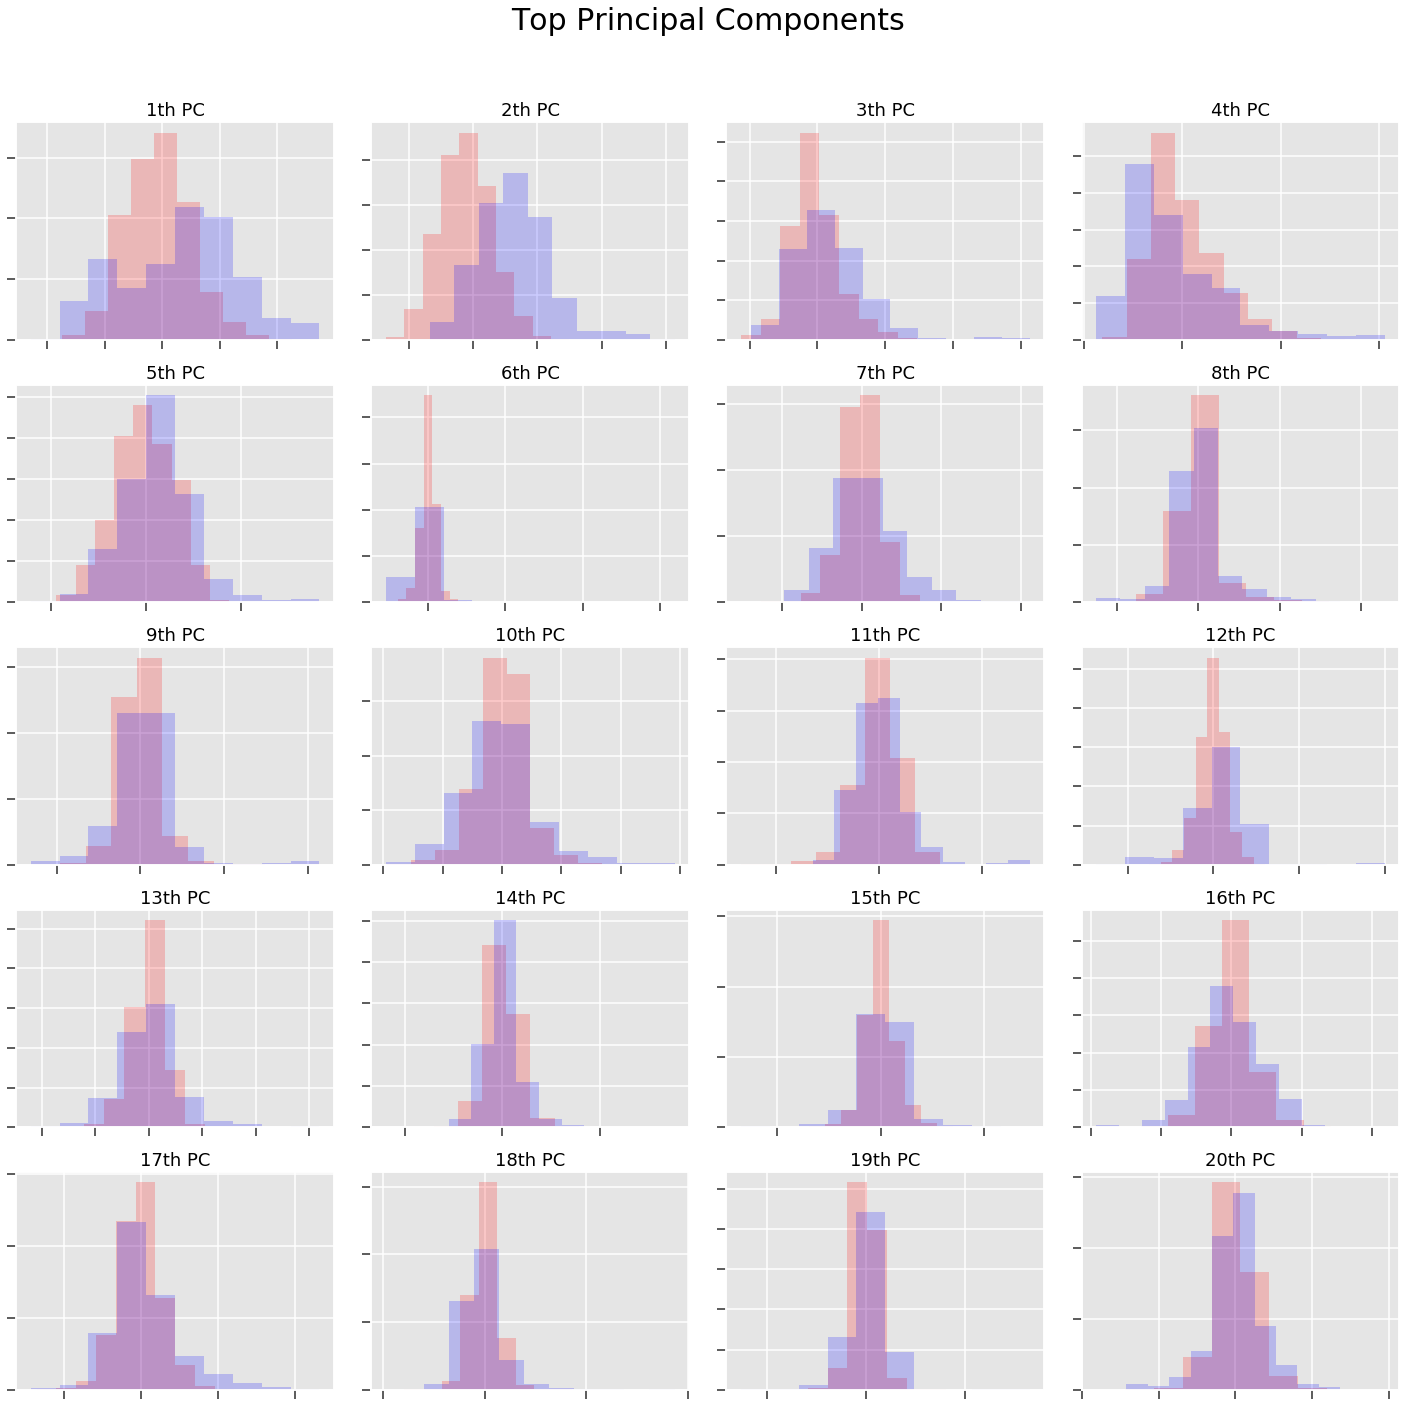

In [979]:
scaler = StandardScaler()
X_scaled_for_pca = scaler.fit_transform(X.iloc[:, 2:])
pca = PCA()
X_pca = pca.fit_transform(X_scaled_for_pca)
df_pca = pd.merge(pd.DataFrame(X_pca), y, left_index=True, right_index=True)

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("Top Principal Components", fontsize=30)
for i in range(20):
    ax[i//4, i%4].hist(df_pca.loc[df_pca.iloc[:, -1]==1, i],
                       color="red",
                       alpha=0.2, 
                       density=True)
    ax[i//4, i%4].hist(df_pca.loc[df_pca.iloc[:, -1]==0, i],
                       color="blue",
                       alpha=0.2, 
                       density=True)
    ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("{}th PC".format(i+1),
                            fontsize=18
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig("../images/pc")
plt.show()

In [980]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [982]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, 2:])
X_test_scaled = scaler.transform(X_test.iloc[:, 2:])

In [983]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
print("train: ", rfc.score(X_train_scaled, y_train))
print("test: ", rfc.score(X_test_scaled, y_test))

train:  0.9961734693877551
test:  0.9438775510204082


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [989]:
rfc_features = pd.merge(pd.DataFrame(rfc.feature_importances_, 
             index=X.iloc[:, 2:].columns, 
             columns=["importance"]
            ).sort_values(by="importance", ascending=False), var_description, how="left",
                        right_index=True, left_index=True)

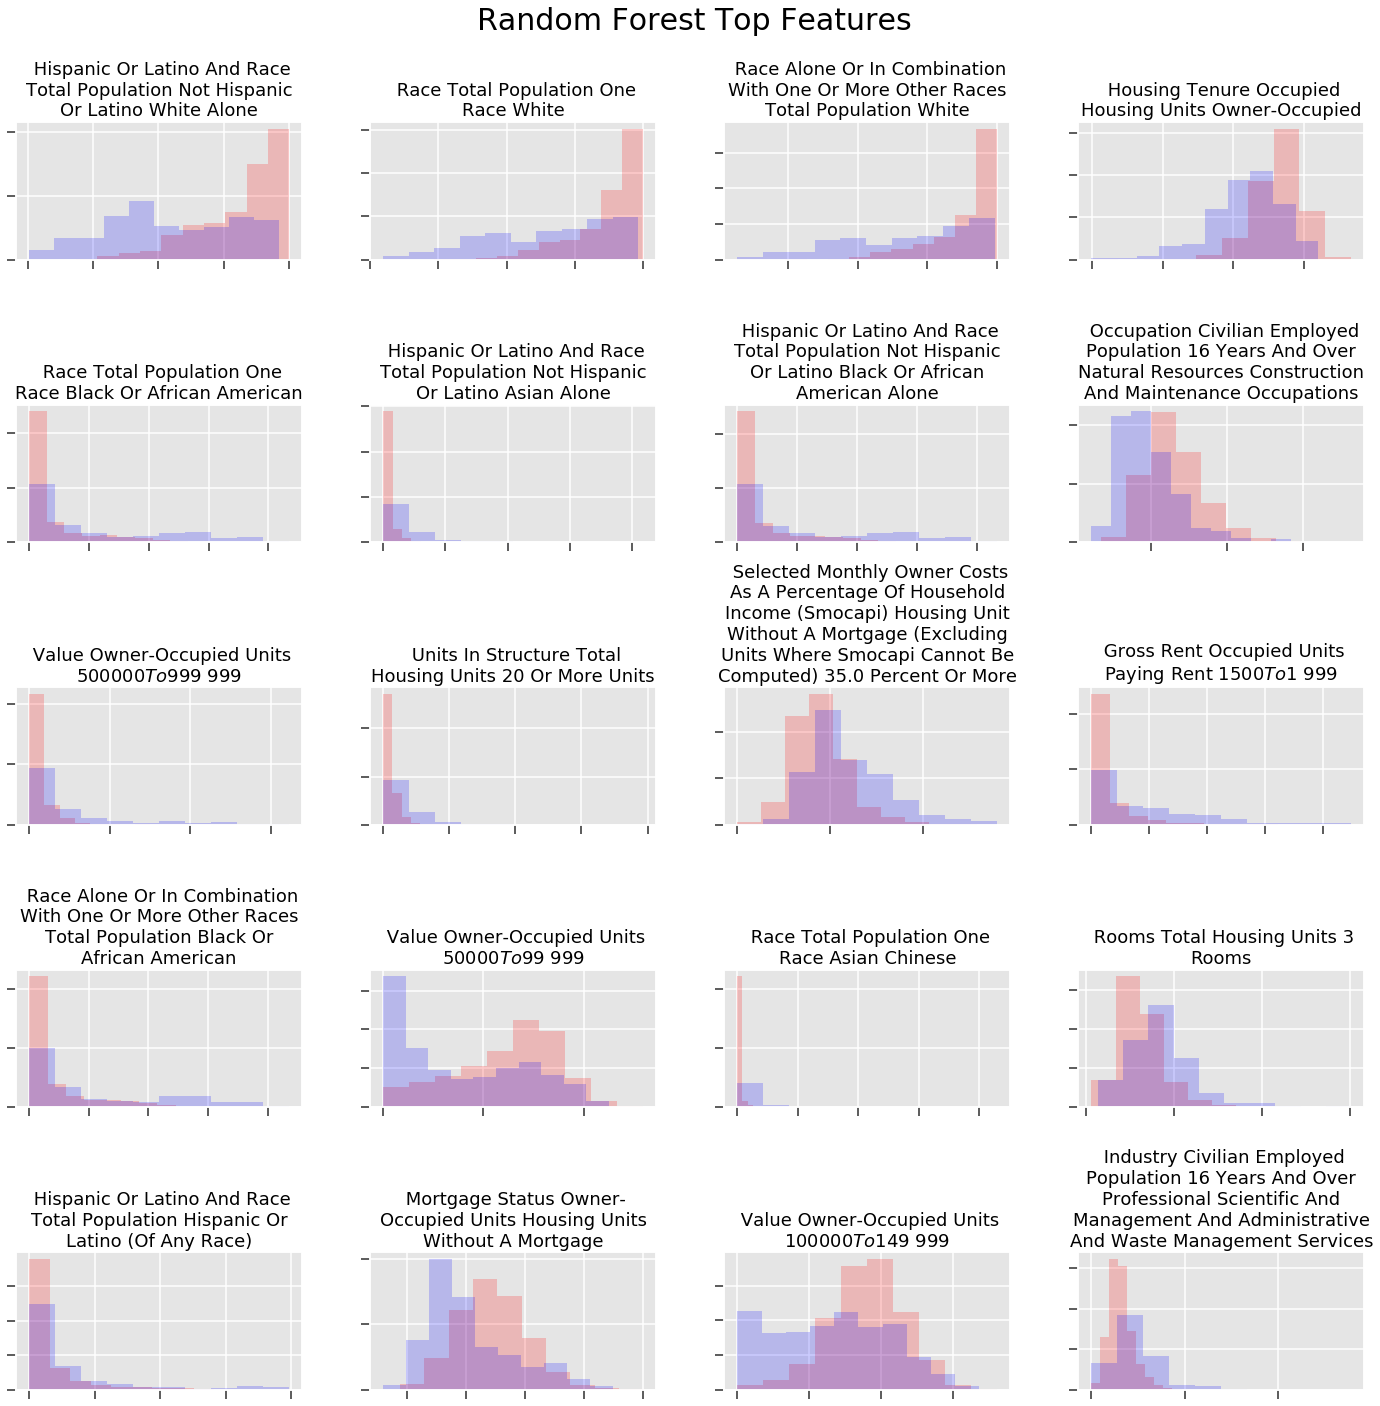

In [990]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("Random Forest Top Features", fontsize=30)
for i in range(20):
    ax[i//4, i%4].hist(X.loc[y==1, rfc_features.index[i]],
                       color="red",
                       alpha=0.2, 
                       density=True)
    ax[i//4, i%4].hist(X.loc[y==0, rfc_features.index[i]], 
                       color="blue",
                       alpha=0.2, 
                       density=True)
    ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("\n".join(wrap(rfc_features.label[i], 30)),
                            fontsize=18
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig("../images/rfc_features")
plt.show()

In [771]:
svc = SVC(probability=True, kernel="linear")
svc.fit(X_train_scaled, y_train)
print("train: ", svc.score(X_train_scaled, y_train))
print("test: ", svc.score(X_test_scaled, y_test))

train:  0.9757653061224489
test:  0.9323979591836735


In [780]:
svc_features = pd.merge(pd.DataFrame(svc.coef_.T, 
             index=X.iloc[:, 2:].columns, 
             columns=["importance"]
            ).apply(lambda x: np.abs(x)).
                        sort_values(by="importance", ascending=False),
                        var_description, 
                        how="left",
                        right_index=True, left_index=True)

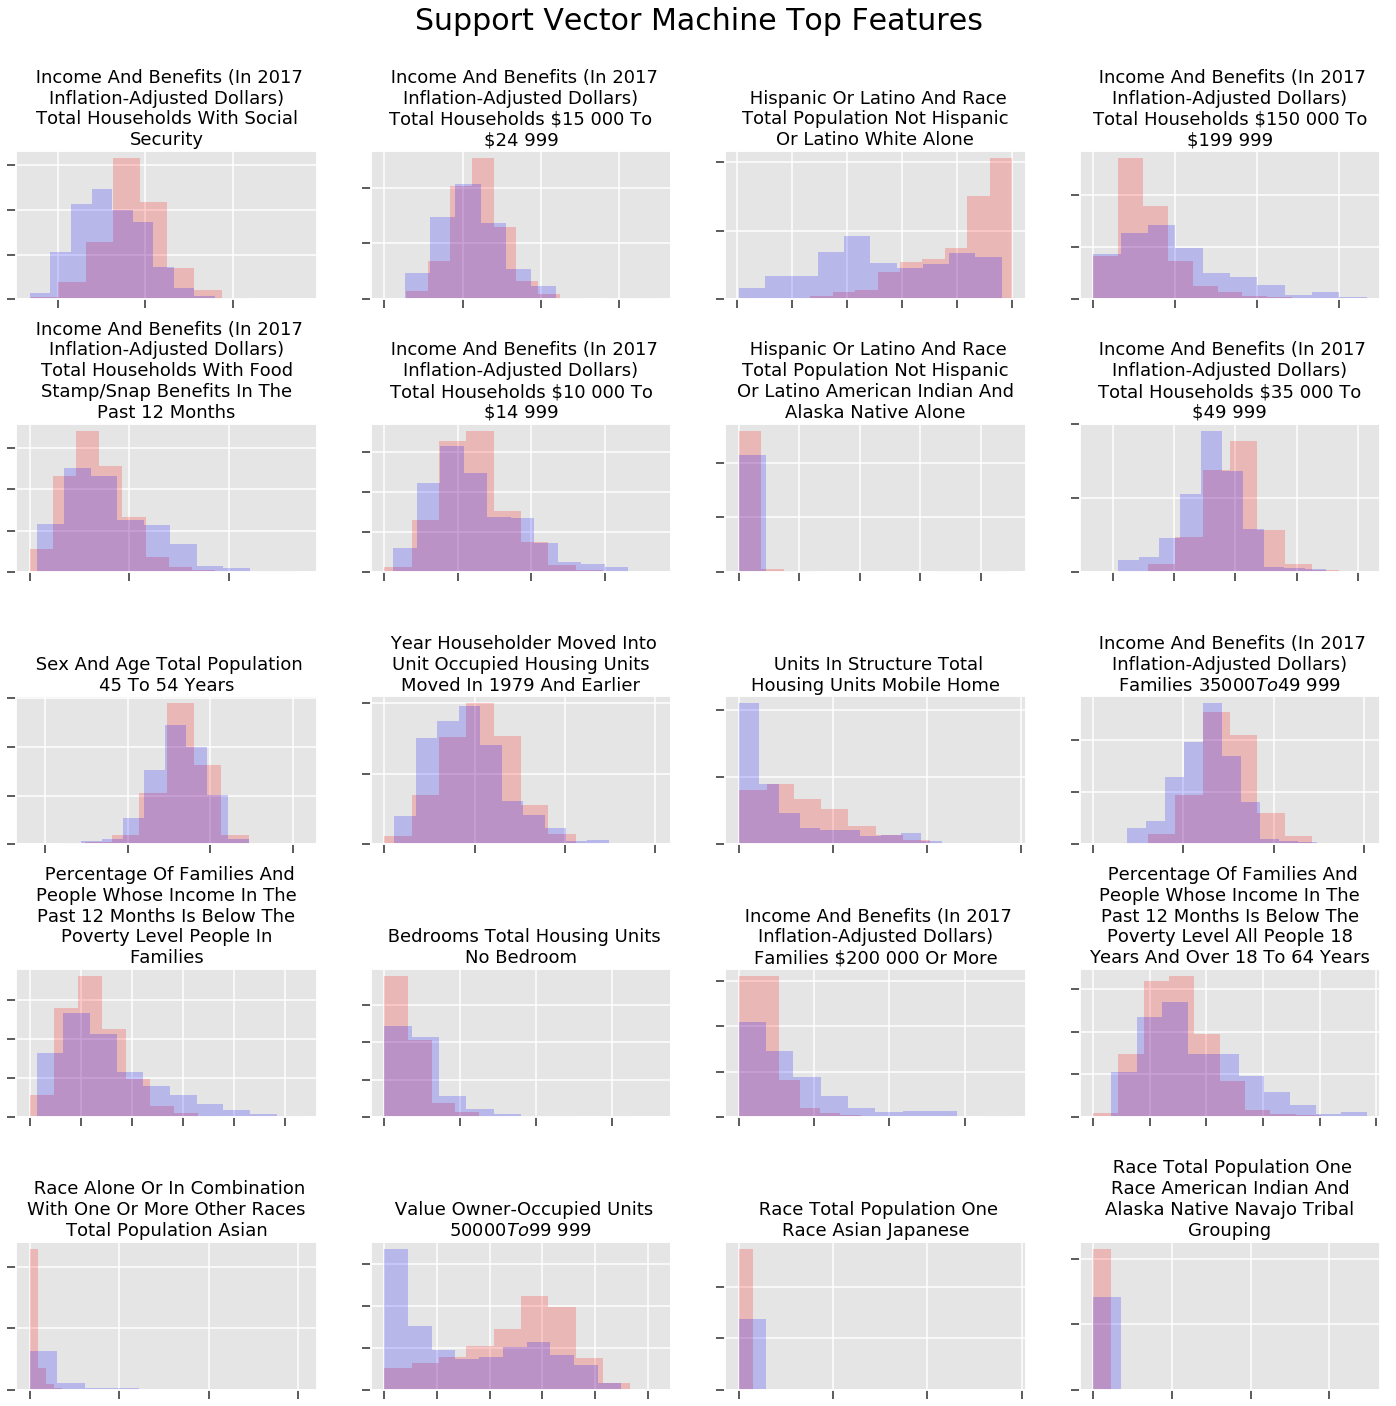

In [783]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("Support Vector Machine Top Features", fontsize=30)
for i in range(20):
    ax[i//4, i%4].hist(X.loc[y==1, svc_features.index[i]],
                       color="red",
                       alpha=0.2, 
                       density=True)
    ax[i//4, i%4].hist(X.loc[y==0, svc_features.index[i]], 
                       color="blue",
                       alpha=0.2, 
                       density=True)
    ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("\n".join(wrap(svc_features.label[i], 30)),
                            fontsize=18
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig("../images/svc_features")
plt.show()

In [506]:
xgc = XGBClassifier()
xgc.fit(X_train_scaled, y_train)
print("train: ", xgc.score(X_train_scaled, y_train))
print("test: ", xgc.score(X_test_scaled, y_test))

train:  0.985969387755102
test:  0.9528061224489796


In [764]:
xgc_features = pd.merge(pd.DataFrame(xgc.feature_importances_, 
             index=X.iloc[:, 2:].columns, 
             columns=["importance"]
            ).sort_values(by="importance", ascending=False), var_description, how="left",
                        right_index=True, left_index=True)

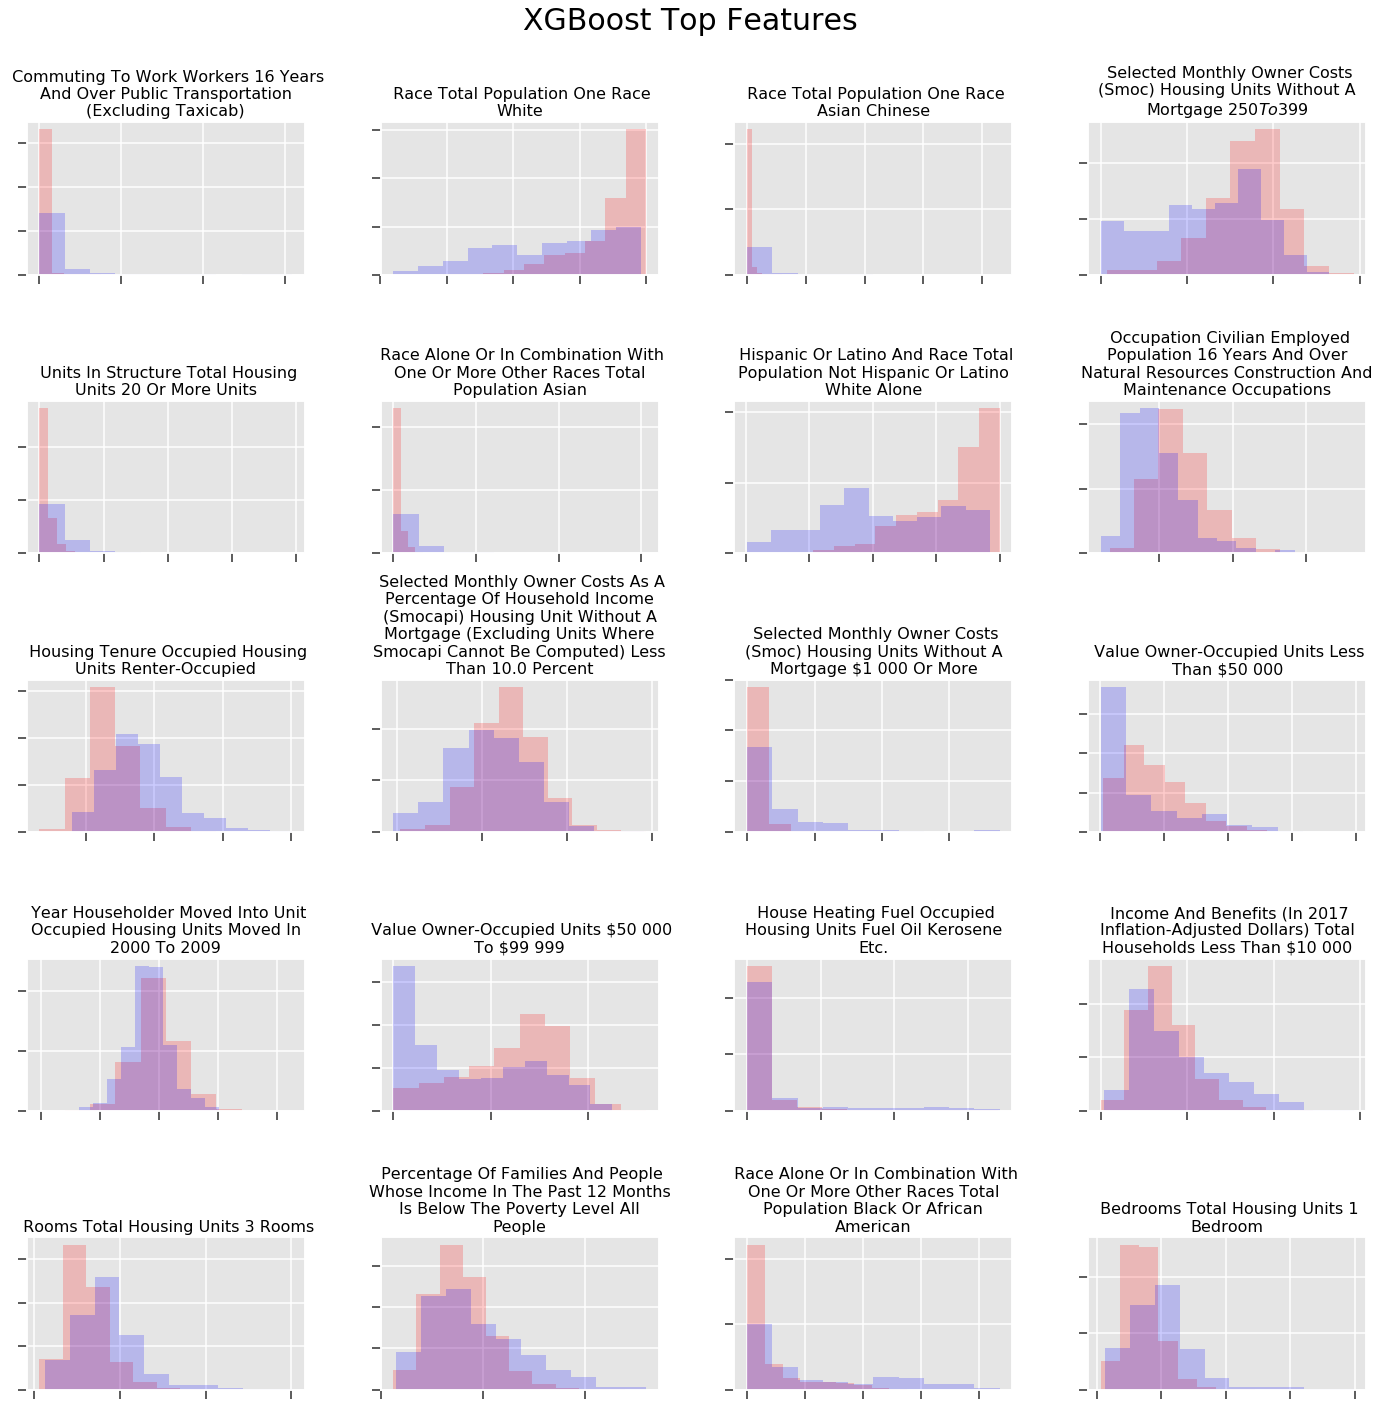

In [768]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("XGBoost Top Features", fontsize=30)
for i in range(20):
    ax[i//4, i%4].hist(X.loc[y==1, xgc_features.index[i]],
                       color="red",
                       alpha=0.2, 
                       density=True)
    ax[i//4, i%4].hist(X.loc[y==0, xgc_features.index[i]], 
                       color="blue",
                       alpha=0.2, 
                       density=True)
    ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("\n".join(wrap(xgc_features.label[i], 35)),
                            fontsize=16
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig("../images/xgc_features")
plt.show()

In [998]:
rfc_trials = y
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.iloc[:, 2:])
    X_test_scaled = scaler.transform(X_test.iloc[:, 2:])
    rfc = RandomForestClassifier()
    rfc.fit(X_train_scaled, y_train)
    pred = pd.DataFrame(rfc.predict(X_test_scaled), index=X_test.index, columns=[i])

    rfc_trials = pd.merge(rfc_trials, pred, how="left", left_index=True, right_index=True)


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kmiyaki/anaconda3/lib/python3

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kmiyaki/anaconda3/lib/python3

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kmiyaki/anaconda3/lib/python3

In [1055]:
rfc_trials["avg"] = rfc_trials.iloc[:, 1:].mean(axis=1)
rfc_trials["diff"] = rfc_trials.target - rfc_trials.avg
rfc_trials["FIPS"] = df.FIPS
rfc_trials["trump"] = df.trump

In [1071]:
county_poly.FIPS.min()

10010210002147

In [1068]:
county_poly.FIPS.max()

721537501021012

In [1069]:
rfc_trials.FIPS.min()

10010210002147

In [1070]:
rfc_trials.FIPS.max()

560459511001744

In [1073]:
county_poly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220255 entries, 0 to 220254
Data columns (total 8 columns):
NAME            220255 non-null object
state           220255 non-null object
county          220255 non-null object
longitude       220255 non-null float64
latitude        220255 non-null float64
FIPS            220255 non-null int64
state_county    220255 non-null object
geometry        220255 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 15.1+ MB


In [1074]:
rfc_poly = pd.merge(county_poly, rfc_trials[["FIPS", "diff", "trump"]], how="left", on="FIPS")

In [1075]:
rfc_poly.shape

(223258, 10)

In [1096]:
rfc_poly = gpd.GeoDataFrame(rfc_poly)

In [ ]:
import descartes

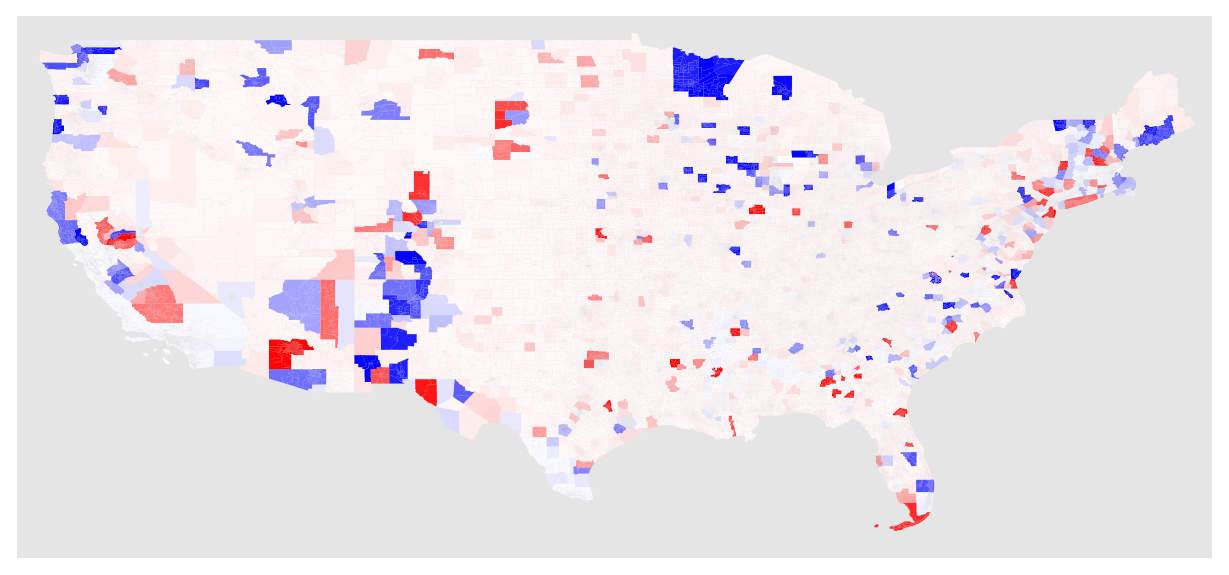

In [1098]:
fig, ax = plt.subplots(1, figsize=(25, 10))
ax = rfc_poly.plot(column='diff', cmap='bwr', ax=ax)
ax.set_xlim([-126, -66])
ax.set_ylim([23, 50.25])
plt.xticks([], [])
plt.yticks([], [])
plt.savefig("../images/rfc_diff_map")
plt.show()